## Data processing - Model initialization - Model fit

In [2]:
import pandas as pd
import numpy as np
import pickle
import cv2
import sys
import matplotlib.pyplot as plt

import keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, UpSampling2D
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### Data processing

In [3]:
ships = pd.read_csv('../input/airbus-ship-detection/train_ship_segmentations_v2.csv')
TRAIN_PICS_DIRECTORY = '../input/airbus-ship-detection/train_v2'
CSV_SHIP_PATH = "/kaggle/working/train_grouped_ship_segmentations_v2.csv"

In [4]:
ships.head(10)

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,NaN
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


Replace np.nan with string 'none'

In [5]:
ships['EncodedPixels'].replace(to_replace=np.nan, value="none", inplace=True)

Group ships from the same image together

In [6]:
unique_ships = ships.groupby('ImageId', as_index=False)['EncodedPixels'].apply(' '.join)
print(unique_ships.head())
print(unique_ships.shape)

         ImageId                                      EncodedPixels
0  00003e153.jpg                                               none
1  0001124c7.jpg                                               none
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  0001b1832.jpg                                               none
(192556, 2)


In [7]:
unique_ships_selected = unique_ships[unique_ships['EncodedPixels']!="none"]
print(unique_ships_selected.head())
print(unique_ships_selected.shape)

         ImageId                                      EncodedPixels
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
5  00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...
6  0002756f7.jpg  255784 2 256552 4 257319 7 258087 9 258854 12 ...
9  00031f145.jpg  340363 1 341129 4 341896 6 342663 7 343429 10 ...
(42556, 2)


In [8]:
unique_ships_selected.to_csv('train_grouped_selected_ships.csv')

In [9]:
CSV_SHIP_SELECTED_PATH = "/kaggle/working/train_grouped_selected_ships.csv"

In [10]:
def mask_converter(values):
    mask = np.zeros((768*768,), dtype=float)        #create empty one-dimentional vector with zeros
    if values != "none":
        values = values.strip().split()
        start_points = values[0::2]               #separate values
        lengths = values[1::2]
        for st_p, l in zip(start_points, lengths):     #fill mask with ones according to the EncodedPixels colomn
            st_p, l = int(st_p)-1, int(l)
            ones = np.ones(l, dtype=int) 
            mask[int(st_p):int(st_p)+int(l)] = ones
    return np.transpose(mask.reshape((768, 768, 1)), axes=(1, 0, 2))    #rotate image to get correct orientation

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,])
    union = K.sum(y_true, axis=[1,2]) + K.sum(y_pred, axis=[1,2])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1):
    true = K.flatten(y_true)
    pred = K.flatten(y_pred)
    intersection = K.sum(true*pred)
    union = K.sum(true) + K.sum(pred) - intersection
    return (intersection+smooth)/(union+smooth)

def iou_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)
    

# initializing U-net model
def unet_model(input_size=(256,256,3)):
    inputs = Input(input_size)

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    d = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    return Model(inputs=[inputs], outputs=[d])


def data_generator(csv_data_file, image_folder_path, batch_size, epochs, augmentation=False, aug_batch_size=32):              
    """
    Yields the next data batch.
    """
    labels_file = pd.read_csv(csv_data_file)
    num_images = len(labels_file)
    for i in range(epochs):
        for offset in range(0, num_images, batch_size):        
            # Get the samples you'll use in this batch
            batch_images = labels_file['ImageId'][offset:offset+batch_size].values
            batch_masks = labels_file['EncodedPixels'][offset:offset+batch_size].values
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for image_filename, mask_encoded in zip(batch_images, batch_masks):          
                # Add example to arrays
                image = cv2.imread(f"{image_folder_path}/{image_filename}")
                mask = mask_converter(mask_encoded)
                image = cv2.resize(image, (256, 256), interpolation=None)
                mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
                X_train.append(image)
                y_train.append(mask)

            X_train = np.array(X_train)/255
            y_train = np.array(y_train)[..., np.newaxis]

            if augmentation:
                image_gen = ImageDataGenerator(horizontal_flip=True,
                                               vertical_flip=True,
                                               width_shift_range=0.1,
                                               height_shift_range=0.1
                                                          )
                mask_gen = ImageDataGenerator(horizontal_flip=True,
                                              vertical_flip=True,
                                              width_shift_range=0.1,
                                              height_shift_range=0.1
                                                          )
                image_gen.fit(X_train)
                mask_gen.fit(y_train)
                counter = 0
                for X_aug_train, y_aug_train in zip(image_gen.flow(X_train, batch_size=aug_batch_size, seed=42), mask_gen.flow(y_train, batch_size=aug_batch_size, seed=42)):
                    if counter == 4:
                        counter = 0
                        break
                    counter += 1
                    yield X_aug_train, y_aug_train
            else:
                yield X_train, y_train
                # yield the next training batch

### Picture sample

In [11]:
BATCH_SIZE = 32
AUG_ITERATIONS = 10

train_augmented_generator = data_generator(csv_data_file=CSV_SHIP_SELECTED_PATH, image_folder_path=TRAIN_PICS_DIRECTORY, epochs=1, batch_size=8, augmentation=False)

In [12]:
X_aug_train, y_aug_train = next(train_augmented_generator)

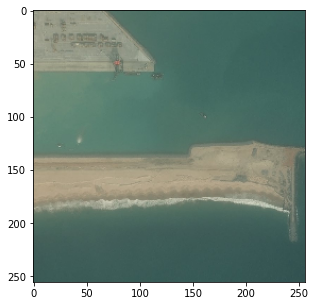

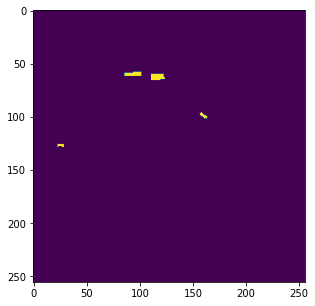

In [13]:
indx=1

plt.figure(figsize=(5,5))
plt.imshow(cv2.cvtColor(X_aug_train[indx].astype('float32'), cv2.COLOR_BGR2RGB))
plt.figure(figsize=(5,5))
plt.imshow(y_aug_train[indx])

## Model

In [14]:
unet_aug = unet_model()
unet_aug.compile(optimizer=Adam(0.01, decay=1e-4),
            loss='binary_crossentropy',
            metrics=[dice_coef, iou_coef])
unet_aug.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [15]:
BATCH_SIZE = 32
AUG_ITERATIONS = 20
DATASET_SIZE = 42556
EPOCHS = 10
STEPS = 2*(int(DATASET_SIZE//BATCH_SIZE)+1)*EPOCHS


checkpoint = ModelCheckpoint("/kaggle/working/model/", monitor='dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="dice_coef", 
                      mode="max", 
                      patience=15)
board = TensorBoard(log_dir='/kaggle/working/board/train_logs', histogram_freq=100, update_freq='batch')

train_augmented_generator = data_generator(csv_data_file=CSV_SHIP_SELECTED_PATH, image_folder_path=TRAIN_PICS_DIRECTORY, epochs=EPOCHS, batch_size=BATCH_SIZE, augmentation=True, aug_batch_size=16)

In [16]:
model_history = unet_aug.fit(train_augmented_generator, steps_per_epoch=STEPS, verbose=1, callbacks=[board, checkpoint, early, reduceLROnPlat])

26600/26600 [==============================] - 12832s 482ms/step - loss: 0.0265 - dice_coef: 0.1604 - iou_coef: 0.1160

Epoch 00001: dice_coef improved from -inf to 0.16036, saving model to /kaggle/working/model/


In [26]:
unet_aug.save("/kaggle/working")

### Test

In [17]:
model_history.history

{'loss': [0.026461545377969742],
 'dice_coef': [0.16036435961723328],
 'iou_coef': [0.11604966968297958],
 'lr': [0.01]}

In [18]:
train_generator = data_generator(csv_data_file=CSV_SHIP_SELECTED_PATH, image_folder_path=TRAIN_PICS_DIRECTORY, epochs=1, batch_size=32, augmentation=False)

In [19]:
X_batch, y_batch = next(train_generator)

In [20]:
y_pred = (unet_aug.predict(X_batch) > 0.25).astype(np.uint8)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


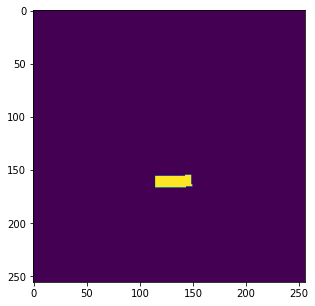

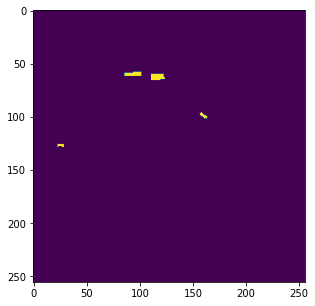

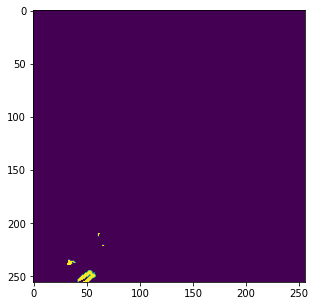

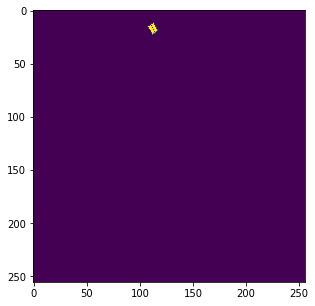

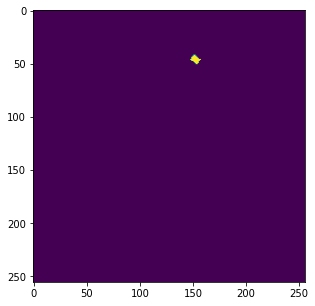

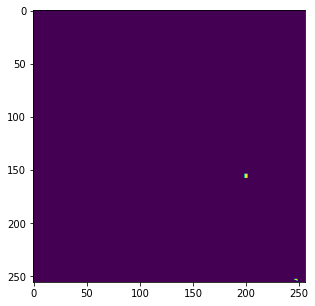

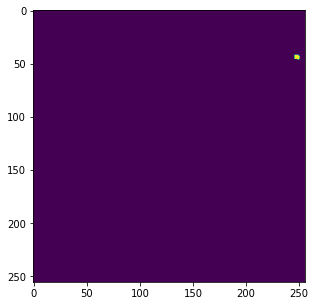

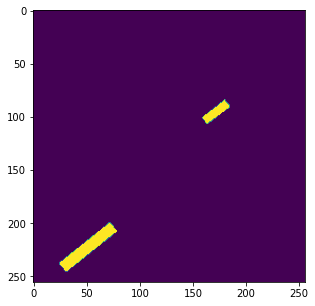

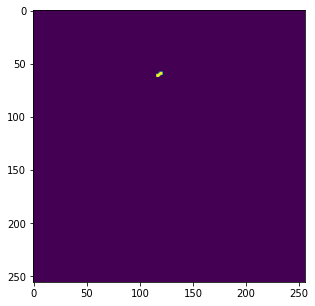

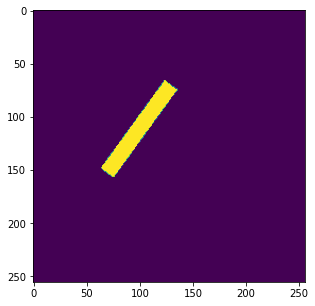

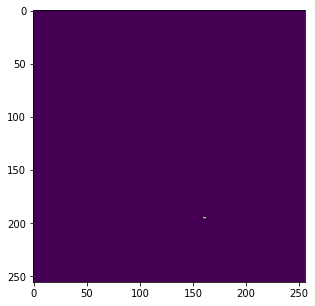

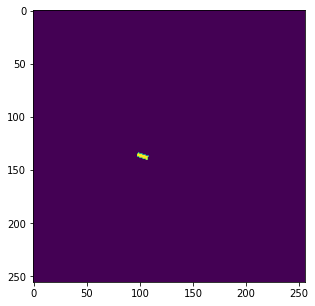

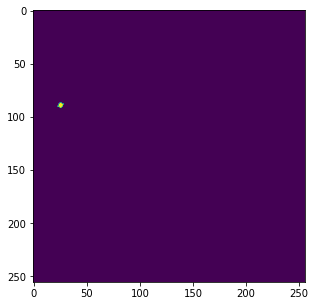

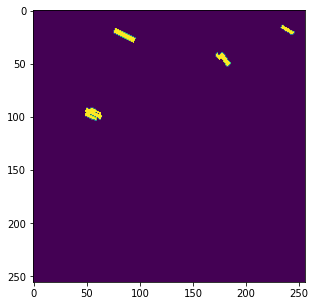

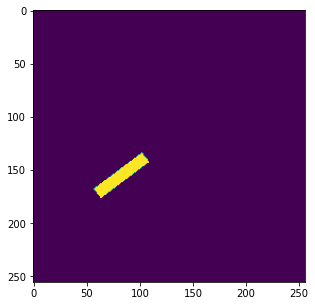

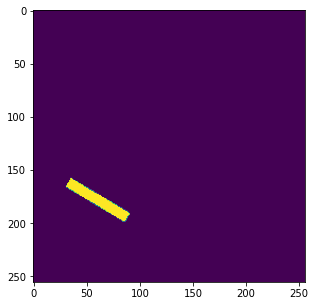

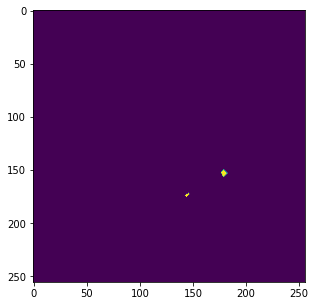

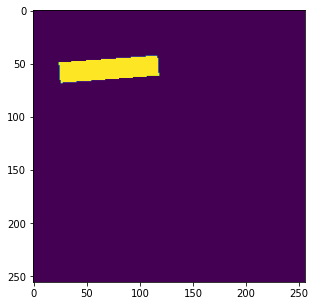

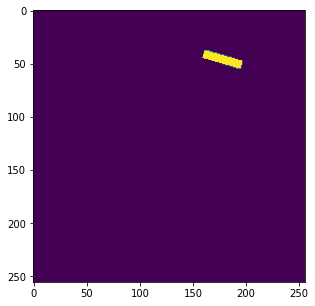

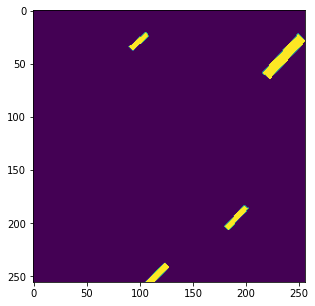

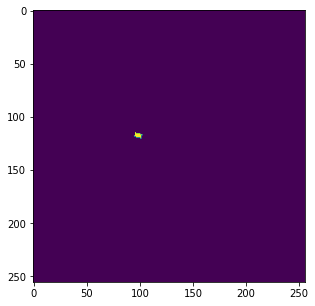

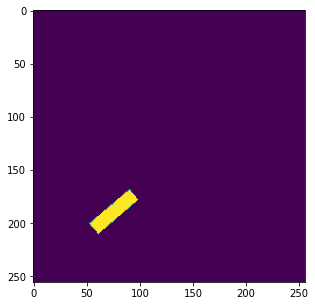

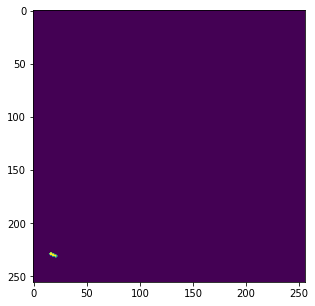

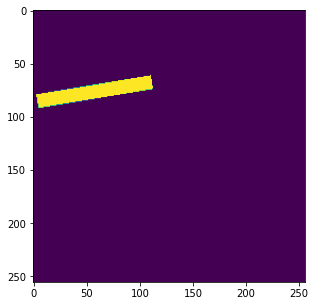

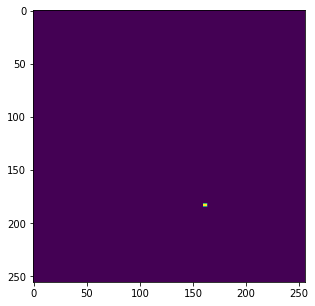

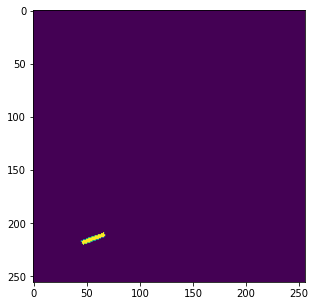

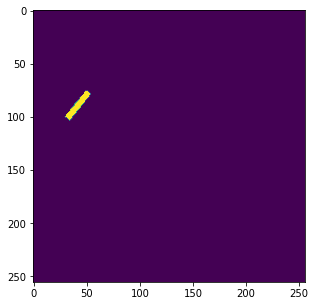

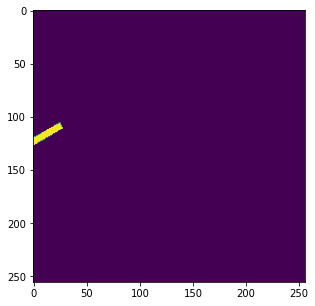

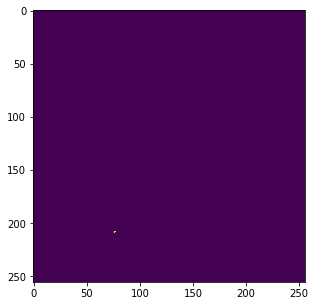

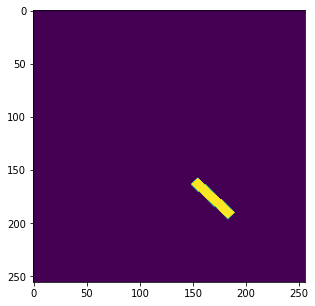

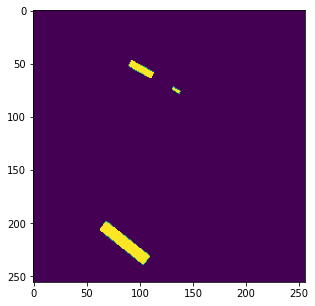

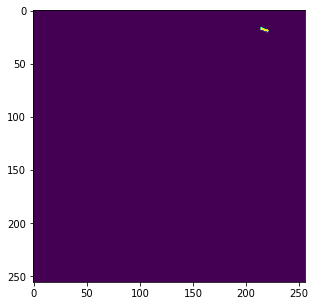

In [21]:
for image in y_batch:
    plt.figure(figsize=(5,5))
    plt.imshow(image)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


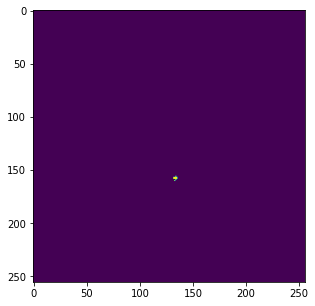

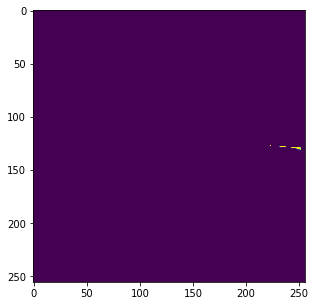

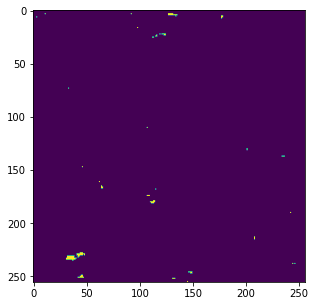

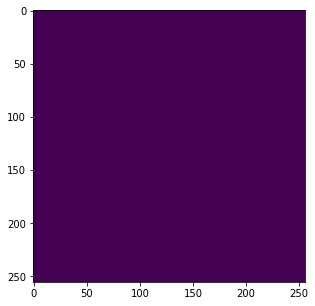

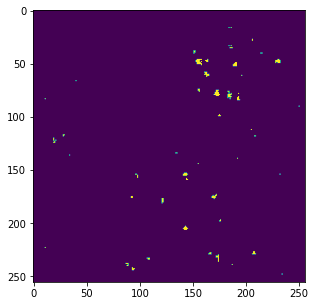

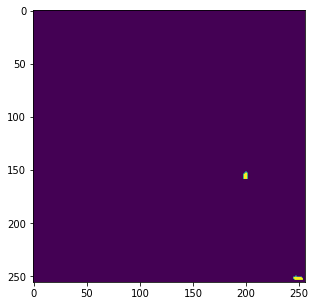

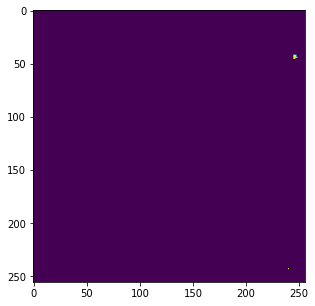

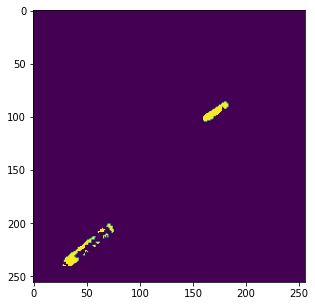

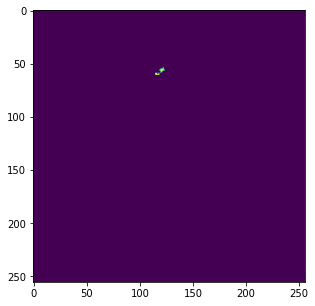

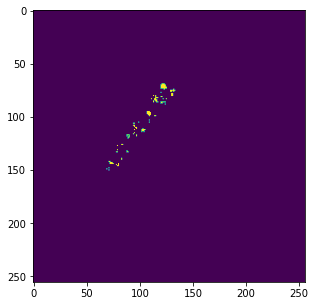

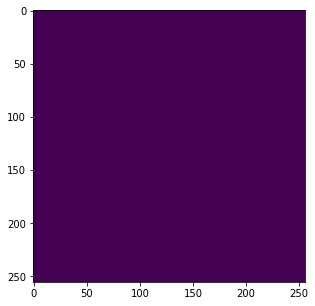

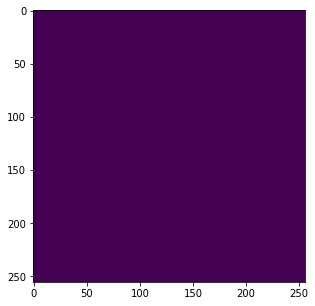

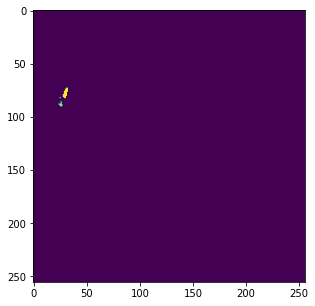

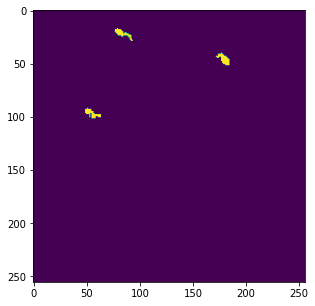

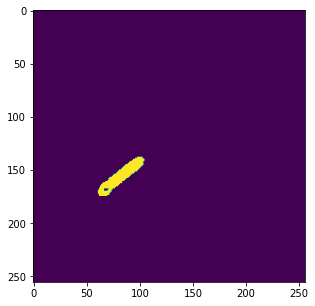

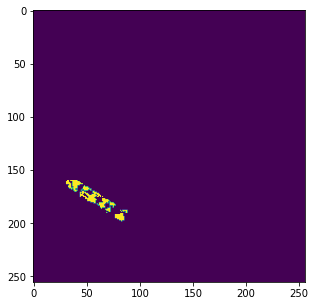

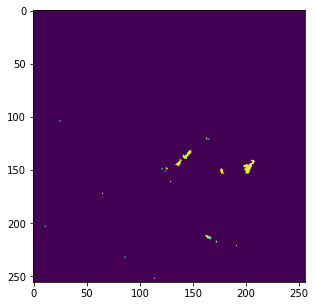

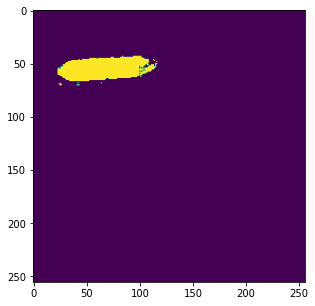

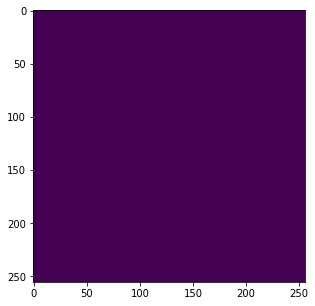

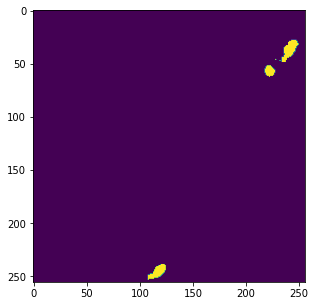

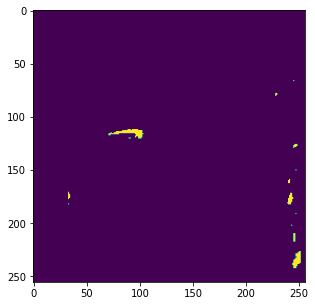

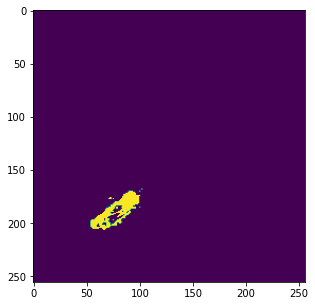

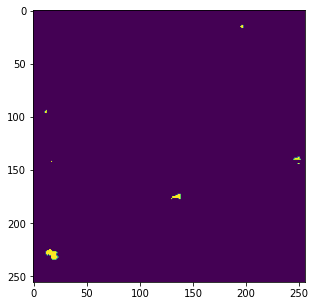

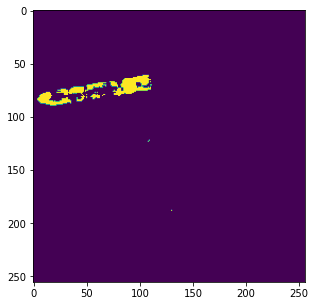

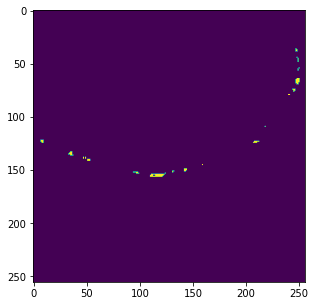

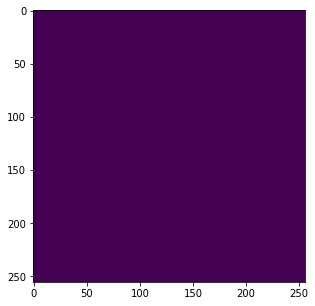

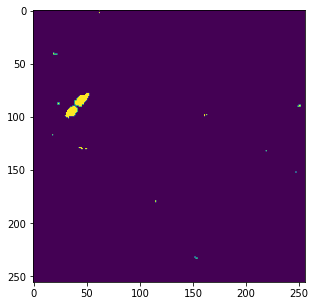

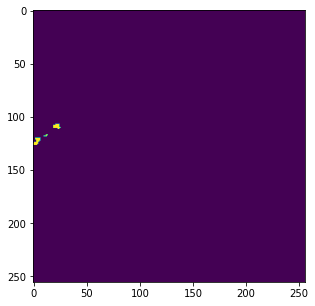

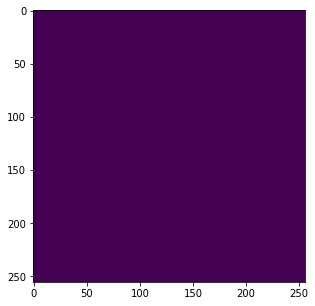

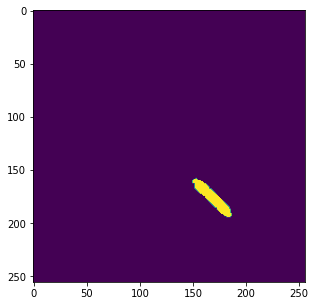

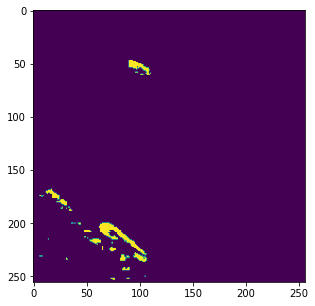

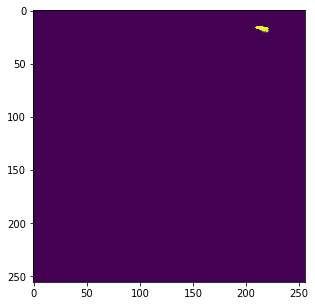

In [22]:
for image in y_pred:
    plt.figure(figsize=(5,5))
    plt.imshow(image)